In [14]:
import numpy as np
import torch
import random
import collections

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
%pdb

Automatic pdb calling has been turned ON


In [6]:
%pdb off

Automatic pdb calling has been turned OFF


In [1]:
num_arms = 20

In [2]:
def random_argmax(x):
    return np.random.choice(np.flatnonzero(np.isclose(x, x.max())))

In [3]:
def select_random(means, visit_counts, n):
    arm = np.random.randint(0, num_arms, 1)
    return arm

In [4]:
def ucb1_confidence_bound(n, visit_count):
    return np.sqrt(2 * np.log(n) / visit_count)

def ucb_e_confidence_bound(n, visit_count):
    return np.sqrt((1 * n / 200) / visit_count)

In [5]:
def select_ucb1(means, visit_counts, n, alpha=2):
    if n == 0:
        return np.random.randint(0, num_arms, 1)
    return random_argmax(means + ucb1_confidence_bound(n, visit_counts))

In [6]:
def select_ucb_e(means, visit_counts, n, alpha=2):
    if n == 0:
        return np.random.randint(0, num_arms, 1)
    return random_argmax(means + ucb_e_confidence_bound(n, visit_counts))

In [122]:
def binomial_arms(arm):
    return np.random.binomial(1, true_means[arm], 1)[0]

def normal_arms(arm):
    sample = np.random.normal(true_means[arm], true_stds[arm], 1)[0]
    sample = sample.clip(0, 1)
    return sample

In [145]:
def run_experiment(selection_strategy, max_n = 200):
    regrets = []
    arm_sums = np.zeros(num_arms)
    arm_visits = np.zeros(num_arms) + 1e-9
    for n in range(max_n):
        # Compute best arm
        arm_means = arm_sums / arm_visits
        best_arm = random_argmax(arm_means)
        regret = max_p - true_means[best_arm]
        #print(regret)
        regrets.append(regret)
        
        arm = selection_strategy(arm_means, arm_visits, n)
        #arm_sums[arm] += binomial_arms(arm)
        arm_sums[arm] += normal_arms(arm)

        arm_visits[arm] += 1
        
    return regrets, arm_sums, arm_visits, best_arm

In [148]:
def run_batch(selection_strategy, batch_size):
    results = []
    for i in range(batch_size):
        regrets, _, _, _ = run_experiment(selection_strategy, 400)
        results.append(regrets)
    regrets = np.array(results).mean(axis=0)
    return regrets

In [149]:
batch_size = 100
#true_means = np.linspace(.5, .66, num_arms)
true_means = np.linspace(.66, .5, num_arms)

#true_means = np.linspace(.75, .25, num_arms)
true_stds = np.ones(num_arms) * .05

#max_p = max(p)
max_p = max(true_means)
#p

In [128]:
random_regrets = run_batch(select_random, batch_size)

In [129]:
ucb1_regrets = run_batch(select_ucb1, batch_size)

In [150]:
mine_regrets = run_batch(select_mine, batch_size)

In [151]:
ucbe_regrets = run_batch(select_ucb_e, batch_size)

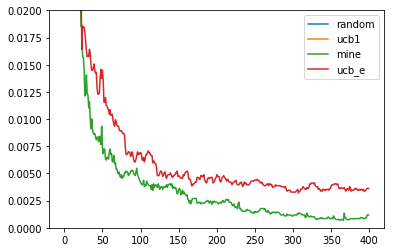

In [153]:
plt.plot(random_regrets, label="random")
plt.plot(ucb1_regrets, label="ucb1")
plt.plot(mine_regrets, label="mine")
#plt.plot(minee_regrets, label="minee")
plt.plot(ucbe_regrets, label="ucb_e")


plt.ylim(0, .02)
plt.legend()

In [112]:
def select_mine(means, visit_counts, n, alpha=2, debug=False, confidence_bound=ucb1_confidence_bound):
    if n < 2:
        return np.random.randint(0, num_arms, 1)

    
    # Get the current best arm
    best_arm = random_argmax(means)    
    
    # Scalar to get current arm down to next higest mean
    best_arm_mean = means[best_arm]
    means_without_best = np.copy(means)
    means_without_best[best_arm] = 0
    next_best_mean = means_without_best.max()
    best_bound = confidence_bound(n, visit_counts[best_arm])
    #print(n)
    #print(visit_counts[best_arm])
    assert best_bound != 0
    s_best = (best_arm_mean - next_best_mean) / best_bound
    
    
    # Scalar to get next highest UCB up to current best mean
    #ucb = means + confidence_bound(n, visit_counts)
    #ucb[best_arm] = 0
    #next_best_arm = np.random.choice(np.flatnonzero(np.isclose(ucb, ucb.max())))
    #bound = confidence_bound(n, visit_counts[next_best_arm])
    #assert bound != 0
    #s_next_best = (best_arm_mean - means[next_best_arm]) / bound
    bounds = confidence_bound(n, visit_counts)
    s_next_bests = (best_arm_mean - means) / bounds
    s_next_bests[best_arm] = 1e9
    next_best_arm = random_argmax(-1 * s_next_bests)
    s_next_best = s_next_bests[next_best_arm]
    bound = bounds[next_best_arm]
    
    if debug:
        print(f"best arm stats: arm {best_arm}, mean {best_arm_mean}, visits {visit_counts[best_arm]}, bound {best_bound}")
        print(f"next arm stats: arm {next_best_arm}, mean {means[next_best_arm]}, visits {visit_counts[next_best_arm]}, bound {bound}")

    # TODO: consider this case
    if s_best == s_next_best:
        if debug:
            print("equal, pulling first arm")
        
        return best_arm
    elif s_best < s_next_best:
        if debug:
            print(f"pulling best arm {best_arm} because {s_best} < {s_next_best}")
            if n > 50:
                plt.errorbar(range(num_arms), means, yerr=s_best * confidence_bound(n, visit_counts))
                plt.show()
        return best_arm
    else:
        if debug:
            print(f"pulling next-best arm {next_best_arm} because {s_best} > {s_next_best}")
            if n > 50:
                plt.errorbar(range(num_arms), means, yerr=s_next_best * confidence_bound(n, visit_counts))
                plt.show()
        return next_best_arm

In [108]:
%pdb off

Automatic pdb calling has been turned OFF


best arm stats: arm 18, mean 0.8083144462365931, visits 1.000000001, bound 1.1774100219267696
next arm stats: arm 11, mean 0.0, visits 1e-09, bound 37232.97411059034
pulling next-best arm 11 because 0.44835743205966316 > 2.170963952102555e-05
best arm stats: arm 18, mean 0.8083144462365931, visits 1.000000001, bound 1.4823038066263592
next arm stats: arm 4, mean 0.0, visits 1e-09, bound 46874.56215620813
pulling next-best arm 4 because 0.20876051363242268 > 1.7244202592077733e-05
best arm stats: arm 18, mean 0.8083144462365931, visits 1.000000001, bound 1.665109221482841
next arm stats: arm 0, mean 0.0, visits 1e-09, bound 52655.37695468318
pulling next-best arm 0 because 0.18584156524881928 > 1.535103332243264e-05
best arm stats: arm 18, mean 0.8083144462365931, visits 1.000000001, bound 1.79412257709704
next arm stats: arm 8, mean 0.0, visits 1e-09, bound 56735.137479944475
pulling next-best arm 8 because 0.17247790534541432 > 1.4247157619426362e-05
best arm stats: arm 18, mean 0.808

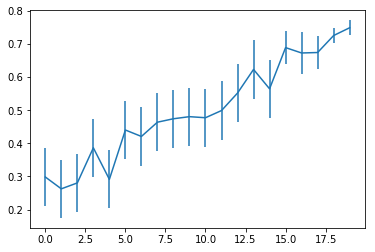

best arm stats: arm 19, mean 0.7488930735549935, visits 15.000000001, bound 0.7275797242261438
next arm stats: arm 18, mean 0.7250241155227476, visits 15.000000001, bound 0.7275797242261438
equal, pulling first arm
best arm stats: arm 19, mean 0.7482801362638624, visits 16.000000001, bound 0.7061324279406592
next arm stats: arm 18, mean 0.7250241155227476, visits 15.000000001, bound 0.7292904356334626
pulling next-best arm 18 because 0.032934361630916516 > 0.03188855852869448


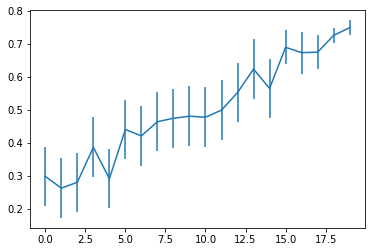

best arm stats: arm 19, mean 0.7482801362638624, visits 16.000000001, bound 0.7077546524910674
next arm stats: arm 15, mean 0.6889307282139705, visits 3.000000001, bound 1.6344893563223741
pulling next-best arm 15 because 0.03634319455112696 > 0.036310672700511755


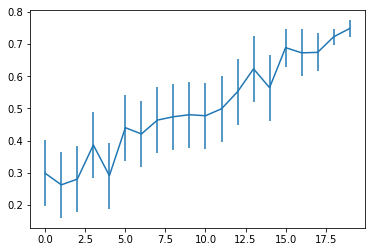

best arm stats: arm 19, mean 0.7482801362638624, visits 16.000000001, bound 0.709344035930694
next arm stats: arm 18, mean 0.7225580712339142, visits 16.000000001, bound 0.709344035930694
equal, pulling first arm
best arm stats: arm 19, mean 0.7468994456395047, visits 17.000000001, bound 0.6896760763615749
next arm stats: arm 18, mean 0.7225580712339142, visits 16.000000001, bound 0.7109018275737744
pulling next-best arm 18 because 0.03529392310373411 > 0.03424013479985664


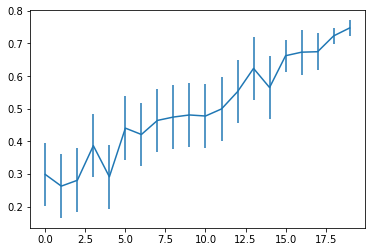

best arm stats: arm 19, mean 0.7468994456395047, visits 17.000000001, bound 0.6911578529418901
next arm stats: arm 16, mean 0.6727145317119009, visits 2.000000001, bound 2.0150540956798646
pulling next-best arm 16 because 0.03859530605397317 > 0.03681534609251986


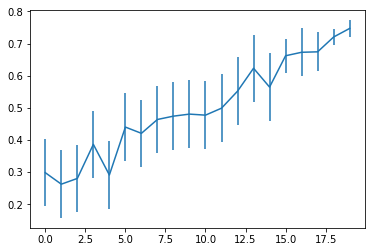

best arm stats: arm 19, mean 0.7468994456395047, visits 17.000000001, bound 0.6926112094747685
next arm stats: arm 16, mean 0.6970937454209452, visits 3.000000001, bound 1.6487444601972214
pulling next-best arm 16 because 0.03851431871298786 > 0.030208259327586674


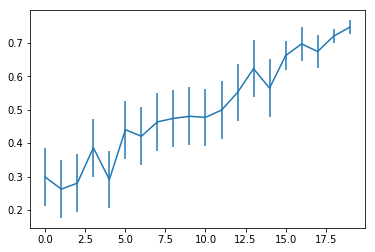

best arm stats: arm 19, mean 0.7468994456395047, visits 17.000000001, bound 0.6940371715745538
next arm stats: arm 18, mean 0.7202239967736055, visits 17.000000001, bound 0.6940371715745538
equal, pulling first arm
best arm stats: arm 19, mean 0.751593225697902, visits 18.000000001, bound 0.6758430014881768
next arm stats: arm 16, mean 0.6893242017735471, visits 4.000000001, bound 1.4336795079698936
pulling next-best arm 16 because 0.046414964503920034 > 0.04343301524378241


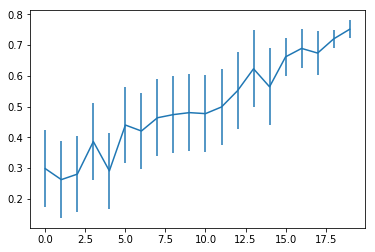

best arm stats: arm 19, mean 0.751593225697902, visits 18.000000001, bound 0.6771783274749393
next arm stats: arm 13, mean 0.6230526344882921, visits 1.000000001, bound 2.873024323223859
pulling next-best arm 13 because 0.04632343896956359 > 0.04474051617682541


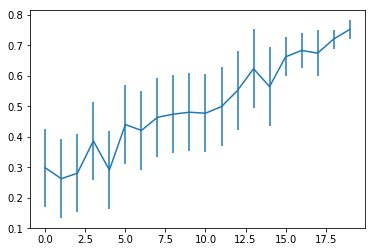

best arm stats: arm 19, mean 0.751593225697902, visits 18.000000001, bound 0.6784897220347686
next arm stats: arm 18, mean 0.7202239967736055, visits 17.000000001, bound 0.6981601641750408
pulling next-best arm 18 because 0.04623390436957719 > 0.044931278715053834


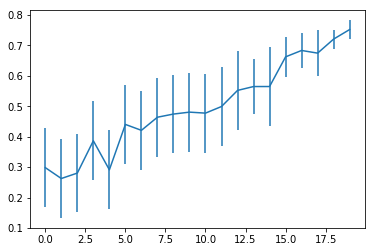

best arm stats: arm 19, mean 0.751593225697902, visits 18.000000001, bound 0.6797779934269899
next arm stats: arm 17, mean 0.6741273926249738, visits 3.000000001, bound 1.6651092220378774
pulling next-best arm 17 because 0.04931652245356204 > 0.046522974017356104


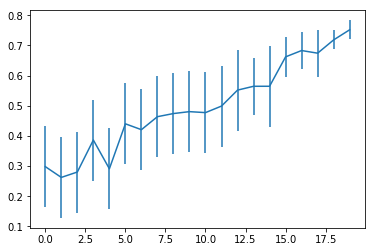

best arm stats: arm 19, mean 0.751593225697902, visits 18.000000001, bound 0.6810439102880328
next arm stats: arm 18, mean 0.7180689390216225, visits 18.000000001, bound 0.6810439102880328
equal, pulling first arm
best arm stats: arm 19, mean 0.7552497037739326, visits 19.000000001, bound 0.6640905725962003
next arm stats: arm 17, mean 0.6783675547116238, visits 4.000000001, bound 1.4473518475096183
pulling next-best arm 17 because 0.05598749069265566 > 0.053119183973541664


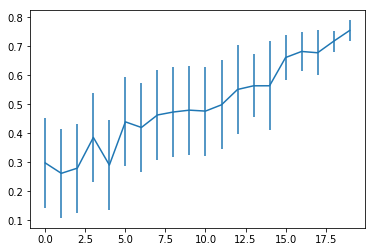

best arm stats: arm 19, mean 0.7552497037739326, visits 19.000000001, bound 0.6652813112289351
next arm stats: arm 17, mean 0.6911988408644443, visits 5.000000001, bound 1.2968720243030962
pulling next-best arm 17 because 0.055887282755062356 > 0.04938873050631773


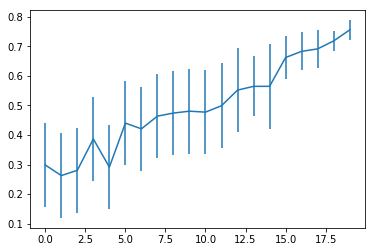

best arm stats: arm 19, mean 0.7552497037739326, visits 19.000000001, bound 0.6664523282160806
next arm stats: arm 17, mean 0.6957383032134321, visits 6.000000001, bound 1.1859606098676374
pulling next-best arm 17 because 0.05578908374712017 > 0.05017991328324342


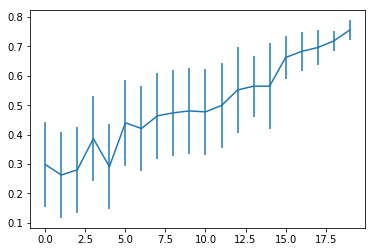

best arm stats: arm 19, mean 0.7552497037739326, visits 19.000000001, bound 0.6676042401850785
next arm stats: arm 18, mean 0.7180689390216225, visits 18.000000001, bound 0.6858981544387242
pulling next-best arm 18 because 0.05569282295451358 > 0.05420741331887013


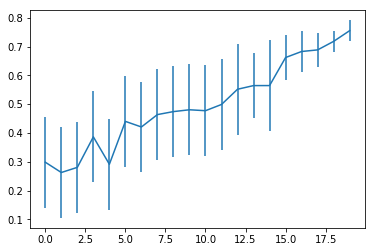

best arm stats: arm 19, mean 0.7552497037739326, visits 19.000000001, bound 0.6687376357401628
next arm stats: arm 16, mean 0.6828647322734686, visits 5.000000001, bound 1.3036096411425715
pulling next-best arm 16 because 0.059626424844035124 > 0.055526569623266214


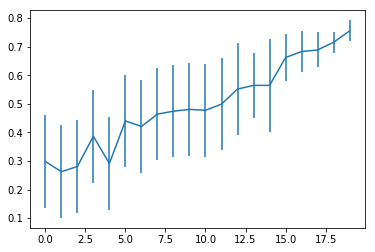

best arm stats: arm 19, mean 0.7552497037739326, visits 19.000000001, bound 0.6698530771207232
next arm stats: arm 16, mean 0.6952475690462778, visits 6.000000001, bound 1.1920122868956886
pulling next-best arm 16 because 0.05952713474010398 > 0.05033684248667943


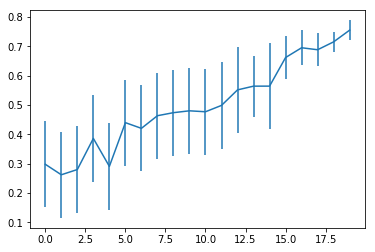

best arm stats: arm 19, mean 0.7552497037739326, visits 19.000000001, bound 0.6709511017394375
next arm stats: arm 16, mean 0.6961391355865792, visits 7.000000001, bound 1.1053979397749034
pulling next-best arm 16 because 0.05942971741825041 > 0.05347446929328483


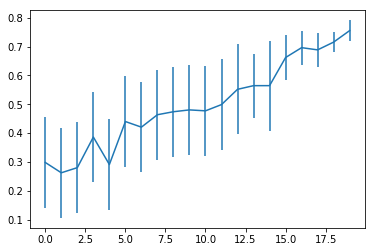

best arm stats: arm 19, mean 0.7552497037739326, visits 19.000000001, bound 0.6720322236104439
next arm stats: arm 18, mean 0.7153752693960941, visits 19.000000001, bound 0.6720322236104439
equal, pulling first arm
best arm stats: arm 19, mean 0.7551705440742479, visits 20.000000001, bound 0.6560537396424905
next arm stats: arm 18, mean 0.7153752693960941, visits 19.000000001, bound 0.6730969346768194
pulling next-best arm 18 because 0.0606585593122902 > 0.05912265028700672


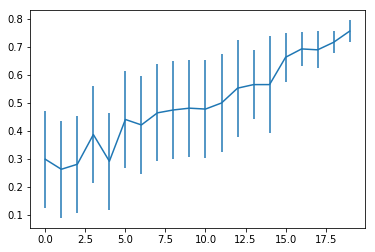

best arm stats: arm 19, mean 0.7551705440742479, visits 20.000000001, bound 0.6570759555272462
next arm stats: arm 18, mean 0.7162173279415931, visits 20.000000001, bound 0.6570759555272462
equal, pulling first arm
best arm stats: arm 19, mean 0.7515824090632063, visits 21.000000001, bound 0.642223321200144
next arm stats: arm 18, mean 0.7162173279415931, visits 20.000000001, bound 0.6580830753081099
pulling next-best arm 18 because 0.05506664107981206 > 0.05373953904688325


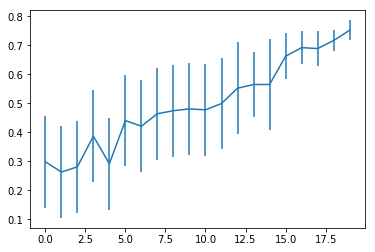

best arm stats: arm 19, mean 0.7515824090632063, visits 21.000000001, bound 0.6431918488620295
next arm stats: arm 18, mean 0.7164180070281329, visits 21.000000001, bound 0.6431918488620295
equal, pulling first arm
best arm stats: arm 19, mean 0.7459828024819627, visits 22.000000001, bound 0.629336506784693
next arm stats: arm 18, mean 0.7164180070281329, visits 21.000000001, bound 0.6441464508488385
pulling next-best arm 18 because 0.04697772198990591 > 0.04589762997975098


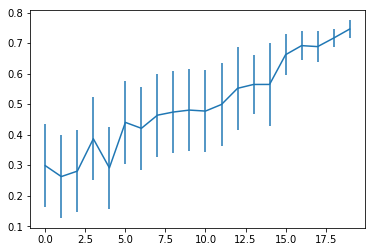

best arm stats: arm 19, mean 0.7459828024819627, visits 22.000000001, bound 0.630255925814586
next arm stats: arm 18, mean 0.7156607422086234, visits 22.000000001, bound 0.630255925814586
equal, pulling first arm
best arm stats: arm 19, mean 0.7454270257830448, visits 23.000000001, bound 0.617289068672774
next arm stats: arm 18, mean 0.7156607422086234, visits 22.000000001, bound 0.6311624653601622
pulling next-best arm 18 because 0.04822097957837077 > 0.04716104839573393


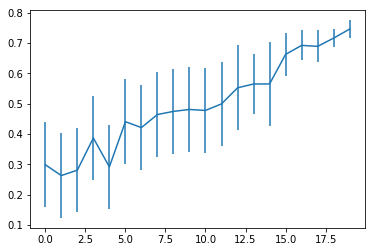

best arm stats: arm 19, mean 0.7454270257830448, visits 23.000000001, bound 0.6181634196821769
next arm stats: arm 18, mean 0.7163116769935899, visits 23.000000001, bound 0.6181634196821769
equal, pulling first arm
best arm stats: arm 19, mean 0.7426744670431451, visits 24.000000001, bound 0.6059922474119506
next arm stats: arm 18, mean 0.7163116769935899, visits 23.000000001, bound 0.6190258298377523
pulling next-best arm 18 because 0.04350351041971981 > 0.042587544459114


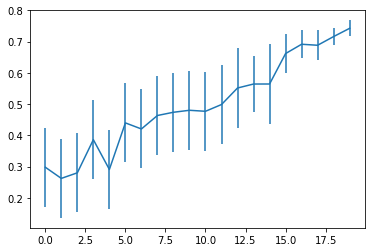

best arm stats: arm 19, mean 0.7426744670431451, visits 24.000000001, bound 0.6068251126156861
next arm stats: arm 18, mean 0.7150618420201375, visits 24.000000001, bound 0.6068251126156861
equal, pulling first arm
best arm stats: arm 19, mean 0.7408977315762679, visits 25.000000001, bound 0.5953699218916643
next arm stats: arm 18, mean 0.7150618420201375, visits 24.000000001, bound 0.6076468820141826
pulling next-best arm 18 because 0.043394683886687296 > 0.04251793322873902


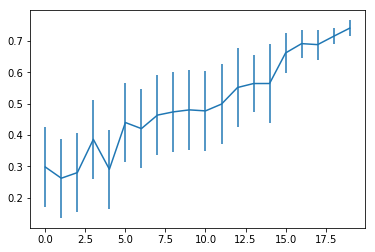

best arm stats: arm 19, mean 0.7408977315762679, visits 25.000000001, bound 0.5961644911473752
next arm stats: arm 18, mean 0.7171897446725738, visits 25.000000001, bound 0.5961644911473752
equal, pulling first arm
best arm stats: arm 19, mean 0.7418029293172512, visits 26.000000001, bound 0.5853563869119647
next arm stats: arm 18, mean 0.7171897446725738, visits 25.000000001, bound 0.596948727853596
pulling next-best arm 18 because 0.042048203786626076 > 0.04123165608071103


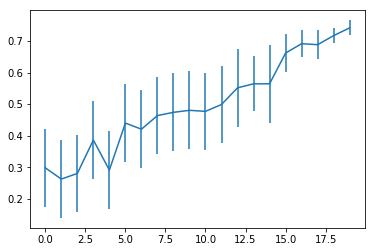

best arm stats: arm 19, mean 0.7418029293172512, visits 26.000000001, bound 0.5861155122750528
next arm stats: arm 18, mean 0.7162117941963417, visits 26.000000001, bound 0.5861155122750528
equal, pulling first arm
best arm stats: arm 19, mean 0.7440550576933189, visits 27.000000001, bound 0.5758945900405333
next arm stats: arm 18, mean 0.7162117941963417, visits 26.000000001, bound 0.5868649965514937
pulling next-best arm 18 because 0.04834784694716005 > 0.047444069182160056


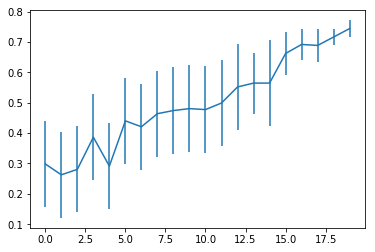

best arm stats: arm 19, mean 0.7440550576933189, visits 27.000000001, bound 0.5766208311627381
next arm stats: arm 18, mean 0.7162753132706617, visits 27.000000001, bound 0.5766208311627381
equal, pulling first arm
best arm stats: arm 19, mean 0.7454214243966262, visits 28.000000001, bound 0.5669347197347175
next arm stats: arm 17, mean 0.6884586039713118, visits 7.000000001, bound 1.133869439408692
pulling next-best arm 17 because 0.05140999503364797 > 0.05023754803288489


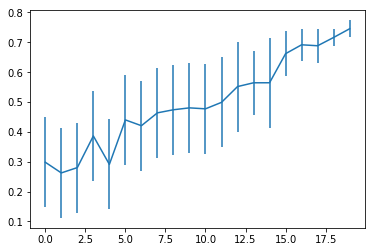

best arm stats: arm 19, mean 0.7454214243966262, visits 28.000000001, bound 0.5676303818982754
next arm stats: arm 18, mean 0.7162753132706617, visits 27.000000001, bound 0.578046487067515
pulling next-best arm 18 because 0.05134698926525692 > 0.050421742503488666


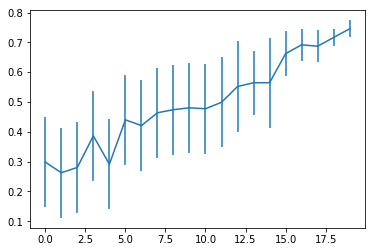

best arm stats: arm 19, mean 0.7454214243966262, visits 28.000000001, bound 0.5683176034130129
next arm stats: arm 16, mean 0.6916830289393625, visits 8.000000001, bound 1.063224879374516
pulling next-best arm 16 because 0.05251536932801628 > 0.050542831060233835


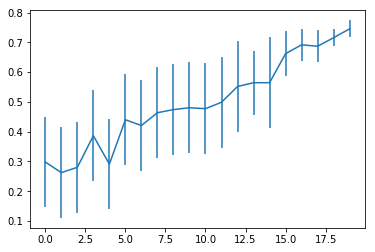

best arm stats: arm 19, mean 0.7454214243966262, visits 28.000000001, bound 0.5689965787614555
next arm stats: arm 18, mean 0.7155760155577787, visits 28.000000001, bound 0.5689965787614555
equal, pulling first arm
best arm stats: arm 19, mean 0.7448150997759634, visits 29.000000001, bound 0.559759479266324
next arm stats: arm 18, mean 0.7155760155577787, visits 28.000000001, bound 0.569667495882325
pulling next-best arm 18 because 0.05223508542724153 > 0.0513265798549695


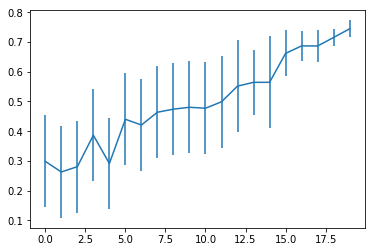

best arm stats: arm 19, mean 0.7448150997759634, visits 29.000000001, bound 0.5604109878223001
next arm stats: arm 18, mean 0.7153449187909643, visits 29.000000001, bound 0.5604109878223001
equal, pulling first arm
best arm stats: arm 19, mean 0.7466838530338014, visits 30.000000001, bound 0.5516247632413234
next arm stats: arm 18, mean 0.7153449187909643, visits 29.000000001, bound 0.5610549294707952
pulling next-best arm 18 because 0.05681205111005322 > 0.055857158714204595


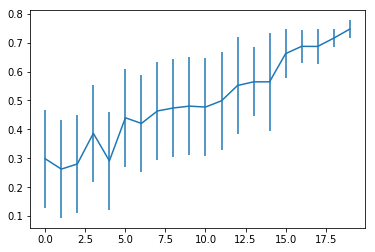

best arm stats: arm 19, mean 0.7466838530338014, visits 30.000000001, bound 0.5522506060567607
next arm stats: arm 18, mean 0.7164488532260517, visits 30.000000001, bound 0.5522506060567607
equal, pulling first arm
best arm stats: arm 19, mean 0.7471491045923953, visits 31.000000001, bound 0.543878987876049
next arm stats: arm 18, mean 0.7164488532260517, visits 30.000000001, bound 0.5528693322728702
pulling next-best arm 18 because 0.05644684212977946 > 0.055528946125721054


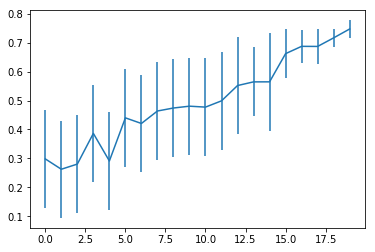

best arm stats: arm 19, mean 0.7471491045923953, visits 31.000000001, bound 0.5444808032983444
next arm stats: arm 18, mean 0.7165369419843804, visits 31.000000001, bound 0.5444808032983444
equal, pulling first arm


(0, 0.02)

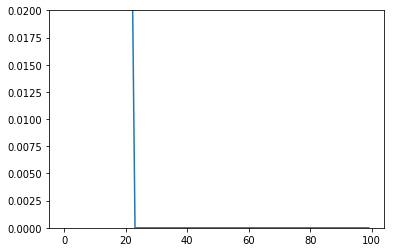

In [109]:
regrets, a, b, c = run_experiment(select_mine, 100)
plt.plot(regrets, label="random")
plt.ylim(0, .02)


In [110]:
a/b

array([0.29832275, 0.26255889, 0.28041391, 0.38637609, 0.29116897,
       0.4401212 , 0.42069479, 0.46375957, 0.47411465, 0.48043826,
       0.4772215 , 0.49886794, 0.55172156, 0.56443593, 0.56450979,
       0.66191317, 0.68718309, 0.68685346, 0.71653694, 0.74722777])

In [111]:
b

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        2.,  1.,  4.,  9.,  8., 31., 32.])

In [360]:
np.sqrt(2 * np.log(1) / 1)

0.0

In [300]:
np.log(2)

0.6931471805599453

In [247]:
means =arm_sums / arm_visits

In [224]:
arm_visits

array([ 5., 35., 31., 40., 50., 38., 42., 48., 40., 39., 55., 57., 57.,
       51., 58., 66., 76., 78., 57., 77.])

In [226]:
best_arm

0

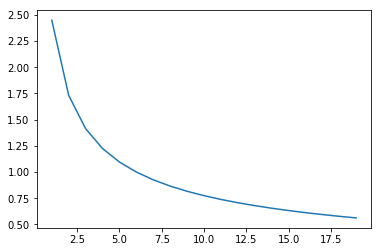

In [267]:
x = np.arange(1, 20)
y = np.sqrt(2 * np.log(20) / x)
plt.plot(x, y)

In [265]:
y

array([2.44774683, 1.73081838, 1.41320729, 1.22387342, 1.09466566,
       0.99928846, 0.92516134, 0.86540919, 0.81591561, 0.77404551,
       0.73802344, 0.70660365, 0.67888282, 0.65418786, 0.63200551,
       0.61193671, 0.59366581, 0.57693946, 0.56155164])

In [231]:
arm_visits.max()

78.000000001